# REMA Project

Author:
- Quentin Fisch

This notebook presents a way to build a recommendation system for a food delivery company based on neural networks. I decided to use a neural network because the data we have is not very structured, not clean at all and has complex relationships between the different features. 

Before choosing this very implementation, I tried to use Bayesian Personnalized Ranking with hard triplets but it performed poorly. This was due to the fact that on average, a customer has 4.7 orders, which doesn't give the flexibility to choose triplets hard enough to make the model learn something. In fact, some users don't have any order, so it was impossible to build a triplet for them. 

Then, I trid KMeans implementation but the results weren't there too. Since each customer has one or more location, we find ourselves with a lot of "users" (cartesian product between customers and their locations). This implies there are very unstructured clusters and it is hard to find a good number of clusters. 

Finally, I decided to use a neural network because it is able to learn complex relationships between features and it is able to learn from unstructured data. Let's start the implementation by importing the libraries we will need.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import List, TypeVar, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

import matplotlib.pyplot as plt

Self = TypeVar("Self")

# set plot size
plt.rcParams["figure.figsize"] = (13, 10)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## User

This section will be focused on the users data. We will briefly analyze it and preprocess it to be able to use it in our neural network.

In [3]:
df_users = pd.read_csv('./data/train_customers.csv')
df_users

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01
...,...,...,...,...,...,...,...,...
34669,JAI79PE,NaN,NaN,1,1,NaN,2020-03-03 13:01:13,2020-03-03 13:02:21
34670,TR75VFL,NaN,NaN,1,1,NaN,2020-03-03 13:22:35,2020-03-03 13:22:41
34671,SQMJ08H,NaN,NaN,1,1,NaN,2020-03-03 13:24:27,2020-03-03 13:24:44
34672,9LW9CHN,NaN,NaN,1,1,NaN,2020-03-03 13:24:28,2020-03-03 13:28:00


In [4]:
df_users.describe(include="all")

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
count,34674,22520,3046.000000,34674.000000,34674.000000,21099,34674,34674
unique,34523,10,NaN,NaN,NaN,1,33650,29409
top,0FOCFVI,Male,NaN,NaN,NaN,EN,2019-10-14 12:20:33,2019-10-01 18:50:31
freq,17,17815,NaN,NaN,NaN,21099,7,15
mean,NaN,NaN,1991.210768,0.998991,0.956538,NaN,NaN,NaN
std,NaN,NaN,48.422045,0.031756,0.203898,NaN,NaN,NaN
min,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,1986.000000,1.000000,1.000000,NaN,NaN,NaN
50%,NaN,NaN,1993.000000,1.000000,1.000000,NaN,NaN,NaN
75%,NaN,NaN,1999.000000,1.000000,1.000000,NaN,NaN,NaN


In [5]:
df_users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   akeed_customer_id  34674 non-null  object 
 1   gender             22520 non-null  object 
 2   dob                3046 non-null   float64
 3   status             34674 non-null  int64  
 4   verified           34674 non-null  int64  
 5   language           21099 non-null  object 
 6   created_at         34674 non-null  object 
 7   updated_at         34674 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 11.2 MB


From this two analysis methods, we can see that:
- `akeed_customer_id` contains duplicates ('0FOCFVI' is present 17 times), we will see it better in the next cell
- `gender` contains 10 different values, but only 3 should be there (male, female and unknown/NaN/other)
- `dob` is useless because less than 10% is not NaN, and these values have weird values (minimum is 1 and max 2562, what should we do with it ?)
- `status` doesn't seem to be very meaning full, but the data looks good, so we will use it
- same for `verified`
- `language` is useless because there is only one (EN)
- `created_at` and `updated_at` are useless because they are all different and it doesn't seem relevant to use them

Let's take a look at duplicate users

In [6]:
df_users.akeed_customer_id.value_counts()

0FOCFVI    17
H0GVNAK    16
XFQVCSZ     9
U0SUJYS     7
F30RUYT     7
           ..
IK3W1ZZ     1
FL6CBI5     1
FA4U8A7     1
XNWWPW9     1
LBMRK7A     1
Name: akeed_customer_id, Length: 34523, dtype: int64

In fact, we can see that there are 17 users with the same id. Let's take a look at them.

In [7]:
df_users[df_users.akeed_customer_id == '0FOCFVI']

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
24306,0FOCFVI,Male,1970.0,1,1,NaN,2019-11-25 20:44:04,2019-11-25 22:23:12
24308,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:44:45,2019-11-25 20:44:45
24309,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:44:49,2019-11-25 20:44:49
24310,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:02,2019-11-25 20:45:02
24311,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:06,2019-11-25 20:45:06
24312,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:11,2019-11-25 20:45:11
24313,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:27,2019-11-25 20:45:27
24314,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:31,2019-11-25 20:45:31
24315,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:37,2019-11-25 20:45:37
24316,0FOCFVI,male,NaN,1,0,NaN,2019-11-25 20:45:48,2019-11-25 20:45:48


Here we see that for the 17 users with the same id, only one is verified and this is the first row. So we will keep only this one and drop the others.

In [8]:
df_users = df_users.drop_duplicates(subset=['akeed_customer_id'], keep='first')
df_users.akeed_customer_id.value_counts()

TCHWPBT    1
L974CDZ    1
ST8C4LD    1
MZK56XR    1
M9X1Y95    1
          ..
IK3W1ZZ    1
FL6CBI5    1
FA4U8A7    1
XNWWPW9    1
LBMRK7A    1
Name: akeed_customer_id, Length: 34523, dtype: int64

Good!
Let's now take a look at the `gender` column.

In [9]:
df_users.gender.value_counts()

Male          17815
male           2763
Female         1761
Female           13
Male              9
Female            2
Female            2
?????             2
Female            1
                  1
Name: gender, dtype: int64

There are multiple case conventions used there, so we will normalize them.

In [10]:
df_users["gender"] = df_users["gender"].astype(str).apply(lambda x: "M" if str.upper(x).startswith("M") else ("F" if str.upper(x).startswith("F") else "NA"))
df_users

/var/folders/d4/5g8l86tn7gnbb_cwzfq_vd180000gn/T/ipykernel_36973/2201611209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users["gender"] = df_users["gender"].astype(str).apply(lambda x: "M" if str.upper(x).startswith("M") else ("F" if str.upper(x).startswith("F") else "NA"))


,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,M,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,M,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,M,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,M,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,M,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01
...,...,...,...,...,...,...,...,...
34669,JAI79PE,NA,NaN,1,1,NaN,2020-03-03 13:01:13,2020-03-03 13:02:21
34670,TR75VFL,NA,NaN,1,1,NaN,2020-03-03 13:22:35,2020-03-03 13:22:41
34671,SQMJ08H,NA,NaN,1,1,NaN,2020-03-03 13:24:27,2020-03-03 13:24:44
34672,9LW9CHN,NA,NaN,1,1,NaN,2020-03-03 13:24:28,2020-03-03 13:28:00


In [11]:
df_users.gender.value_counts()

M     20587
NA    12157
F      1779
Name: gender, dtype: int64

The preprocessing on the customers data is now done. Let's now take a look at the locations of the customers

## User location

In [12]:
df_users_loc = pd.read_csv('./data/train_locations.csv')
df_users_loc

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464
...,...,...,...,...,...
59498,9PP42SA,2,NaN,-0.788515,-78.497721
59499,9PP42SA,3,Home,-1.445114,0.072558
59500,9PP42SA,4,NaN,-0.001785,0.431695
59501,HWELAU8,0,NaN,-0.066291,-78.583075


Let's replace NaN `location_type` with "Other". This will maybe be useful later.

In [13]:
df_users_loc.location_type = df_users_loc.location_type.fillna("Other")
df_users_loc

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,Other,1.682392,-78.789737
1,02SFNJH,1,Other,1.679137,0.766823
2,02SFNJH,2,Other,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,Other,2.523125,0.733464
...,...,...,...,...,...
59498,9PP42SA,2,Other,-0.788515,-78.497721
59499,9PP42SA,3,Home,-1.445114,0.072558
59500,9PP42SA,4,Other,-0.001785,0.431695
59501,HWELAU8,0,Other,-0.066291,-78.583075


The data here is pretty clean and we can use it as it is. Let's now take a look at the orders data.

## Orders

In [14]:
df_orders = pd.read_csv('./data/orders.csv')
df_orders

/var/folders/d4/5g8l86tn7gnbb_cwzfq_vd180000gn/T/ipykernel_36973/682266883.py:1: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv('./data/orders.csv')


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135298,415507.0,L6LFY6H,1.0,13.3,2,NaN,0.0,0.0,No,No,...,2020-02-29 23:59:21,2020-03-01 00:02:10,2020-03-01 00:22:53,2020-03-01 00:29:42,NaN,67,2020-02-29 23:47:59,0,NaN,L6LFY6H X 0 X 67
135299,415508.0,2GMMVGI,3.0,9.5,1,NaN,0.0,0.0,No,Yes,...,2020-03-01 00:19:46,2020-03-01 00:20:05,2020-03-01 00:27:50,2020-03-01 01:03:14,NaN,79,2020-02-29 23:48:37,0,Work,2GMMVGI X 0 X 79
135300,415510.0,LYTAAV0,4.0,18.2,2,NaN,0.0,0.0,No,No,...,2020-03-01 00:04:28,2020-03-01 00:10:34,2020-03-01 00:14:43,2020-03-01 00:36:37,NaN,28,2020-02-29 23:48:43,2,Other,LYTAAV0 X 2 X 28
135301,415512.0,NEV9A5D,3.0,7.7,1,NUE5BZAA7,0.0,0.0,No,No,...,2020-03-01 00:06:14,2020-03-01 00:08:10,2020-03-01 00:22:11,2020-03-01 00:36:52,NaN,841,2020-02-29 23:50:10,0,NaN,NEV9A5D X 0 X 841


In [15]:
df_orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   akeed_order_id                  135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  float64
 12  deliverydistance

In [16]:
df_orders.describe(include="all")

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
count,135233.000000,135303,128378.000000,135303.000000,135303.000000,4305,135303.000000,65880.000000,100108,135303,...,46458,84249,83865,85741,35544,135303.000000,135303,135303.000000,86410,135303
unique,NaN,27445,NaN,NaN,NaN,1396,NaN,NaN,2,2,...,46458,83592,83622,85501,112,NaN,134213,NaN,3,80142
top,NaN,XW90EAP,NaN,NaN,NaN,freedelivery,NaN,NaN,No,No,...,2020-01-04 22:01:37,2020-01-27 22:33:02,2019-11-12 21:33:51,2019-10-26 18:05:30,2019-09-17 05:30:00,NaN,2019-11-12 21:15:05,NaN,Home,XW90EAP X 3 X 13
freq,NaN,262,NaN,NaN,NaN,469,NaN,NaN,98449,115194,...,1,4,3,3,500,NaN,4,NaN,51484,69
mean,265190.206155,NaN,2.405404,15.374513,1.345159,NaN,0.001053,0.026639,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,239.214866,NaN,0.867527,NaN,NaN
std,85051.488939,NaN,1.645332,12.556177,0.763712,NaN,0.047331,0.813320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,226.437406,NaN,1.239884,NaN,NaN
min,11044.000000,NaN,1.000000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,0.000000,NaN,NaN
25%,190852.000000,NaN,1.000000,8.200000,1.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,84.000000,NaN,0.000000,NaN,NaN
50%,267166.000000,NaN,2.000000,11.700000,1.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,157.000000,NaN,0.000000,NaN,NaN
75%,336230.000000,NaN,3.000000,18.500000,1.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,299.000000,NaN,1.000000,NaN,NaN


Orders have a lot of information, but we will only use a few of them. We are going to duplicate the initial dataframe in case we need it later, and update the `is_favorite` and `is_rated` columns because we will use them in our neural network.

In [17]:
df_orders2 = df_orders.copy()
df_orders2["is_favorite"] = df_orders2["is_favorite"].astype(str).apply(lambda x: 1 if x.startswith("Y") else 0)
df_orders2["is_rated"] = df_orders2["is_rated"].astype(str).apply(lambda x: 1 if x.startswith("Y") else 0)
df_orders2

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135298,415507.0,L6LFY6H,1.0,13.3,2,NaN,0.0,0.0,0,0,...,2020-02-29 23:59:21,2020-03-01 00:02:10,2020-03-01 00:22:53,2020-03-01 00:29:42,NaN,67,2020-02-29 23:47:59,0,NaN,L6LFY6H X 0 X 67
135299,415508.0,2GMMVGI,3.0,9.5,1,NaN,0.0,0.0,0,1,...,2020-03-01 00:19:46,2020-03-01 00:20:05,2020-03-01 00:27:50,2020-03-01 01:03:14,NaN,79,2020-02-29 23:48:37,0,Work,2GMMVGI X 0 X 79
135300,415510.0,LYTAAV0,4.0,18.2,2,NaN,0.0,0.0,0,0,...,2020-03-01 00:04:28,2020-03-01 00:10:34,2020-03-01 00:14:43,2020-03-01 00:36:37,NaN,28,2020-02-29 23:48:43,2,Other,LYTAAV0 X 2 X 28
135301,415512.0,NEV9A5D,3.0,7.7,1,NUE5BZAA7,0.0,0.0,0,0,...,2020-03-01 00:06:14,2020-03-01 00:08:10,2020-03-01 00:22:11,2020-03-01 00:36:52,NaN,841,2020-02-29 23:50:10,0,NaN,NEV9A5D X 0 X 841


Let's also create a sorted dataframe based on the vendors. We will use it to create item vectors later

In [18]:
df_orders2_sorted = df_orders2.sort_values(by=["vendor_id"])
df_orders2_sorted.set_index("vendor_id", inplace=True)
df_orders2_sorted

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
vendor_id,,,,,,,,,,,,,,,,,,,,,
4,224961.0,XF35APQ,NaN,5.2,1,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-16 15:44:44,1,NaN,XF35APQ X 1 X 4
4,188938.0,44DHJSU,2.0,9.2,2,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,2019-09-10 05:30:00,2019-09-10 18:20:52,0,Other,44DHJSU X 0 X 4
4,362563.0,8AQHKE4,1.0,13.3,1,NaN,0.0,0.0,0,0,...,2020-02-03 12:46:52,2020-02-03 12:49:27,2020-02-03 13:01:06,2020-02-03 13:31:35,2020-02-03 13:48:52,NaN,2020-02-03 12:46:13,1,NaN,8AQHKE4 X 1 X 4
4,188928.0,GSTEZF7,2.0,12.5,1,NaN,0.0,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,2019-09-10 05:30:00,2019-09-10 18:05:31,0,Home,GSTEZF7 X 0 X 4
4,362529.0,UC7UHYW,1.0,6.8,1,NaN,0.0,0.0,0,0,...,2020-02-03 12:26:30,2020-02-03 12:29:33,2020-02-03 12:40:30,2020-02-03 12:56:32,2020-02-03 13:03:37,NaN,2020-02-03 12:25:55,1,Home,UC7UHYW X 1 X 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,357573.0,WE2MUU0,3.0,3.5,1,NaN,0.0,0.0,0,0,...,2020-01-31 18:21:49,2020-01-31 18:25:41,2020-01-31 18:25:21,2020-01-31 18:56:00,2020-01-31 19:44:07,NaN,2020-01-31 18:12:35,0,Home,WE2MUU0 X 0 X 907
907,385488.0,URLS0AY,5.0,15.5,1,NaN,0.0,0.0,0,1,...,2020-02-14 22:36:52,2020-02-14 22:44:20,2020-02-14 22:59:27,2020-02-14 23:01:27,2020-02-14 23:10:24,NaN,2020-02-14 22:23:55,0,NaN,URLS0AY X 0 X 907
907,403061.0,3N0ZNW9,1.0,1.6,2,NaN,0.0,0.0,0,0,...,2020-02-24 00:25:58,2020-02-24 00:30:22,2020-02-24 00:26:41,2020-02-24 00:42:36,2020-02-24 01:12:27,NaN,2020-02-24 00:18:21,0,NaN,3N0ZNW9 X 0 X 907


## Vendors

This section takes a look at the vendors data

In [19]:
df_vendors = pd.read_csv('./data/vendors.csv')
df_vendors

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,130455.0,-1.588060,-0.066441,Restaurants,2.0,0.0,10.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 12:47:39,2020-04-07 20:01:33,3,1
96,855,130463.0,2.145206,0.745025,Restaurants,2.0,0.0,8.0,1.0,NaN,...,1.0,"1,5,8,91,30,48,24","American,Burgers,Desserts,Free Delivery,Fries,...",Y,1.0,1.0,2019-12-21 13:02:32,2020-04-07 01:50:41,3,1
97,856,130464.0,0.251469,0.483632,Restaurants,2.0,0.0,7.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:04:34,2020-04-06 23:53:16,3,1
98,858,130468.0,0.019817,0.587087,Restaurants,2.0,0.0,3.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:12:09,2020-04-07 14:26:08,3,1


In [20]:
df_vendors.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   authentication_id     100 non-null    float64
 2   latitude              100 non-null    float64
 3   longitude             100 non-null    float64
 4   vendor_category_en    100 non-null    object 
 5   vendor_category_id    100 non-null    float64
 6   delivery_charge       100 non-null    float64
 7   serving_distance      100 non-null    float64
 8   is_open               100 non-null    float64
 9   OpeningTime           91 non-null     object 
 10  OpeningTime2          91 non-null     object 
 11  prepration_time       100 non-null    int64  
 12  commission            85 non-null     float64
 13  is_akeed_delivering   100 non-null    object 
 14  discount_percentage   100 non-null    float64
 15  status                10

In [21]:
df_vendors.describe(include="all")

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
count,100.000000,100.000000,100.000000,100.000000,100,100.000000,100.000000,100.000000,100.00000,91,...,100.0,97,97,100,100.0,100.0,100,100,100.00,100.0
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,68,...,NaN,77,77,1,NaN,NaN,100,98,NaN,NaN
top,NaN,NaN,NaN,NaN,Restaurants,NaN,NaN,NaN,NaN,11:00AM-11:00PM,...,NaN,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,NaN,NaN,2018-01-30 14:42:04,2020-04-02 12:35:56,NaN,NaN
freq,NaN,NaN,NaN,NaN,88,NaN,NaN,NaN,NaN,5,...,NaN,7,7,100,NaN,NaN,1,3,NaN,NaN
mean,288.840000,120050.760000,1.875505,0.803682,NaN,2.110000,0.413000,11.750000,0.85000,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.98,1.0
std,242.299994,3509.069064,20.600857,4.397859,NaN,0.314466,0.346018,4.108073,0.35887,NaN,...,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.20,0.0
min,4.000000,118597.000000,-1.787413,-1.449556,NaN,2.000000,0.000000,2.000000,0.00000,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.00,1.0
25%,105.750000,118702.750000,-0.809124,0.081618,NaN,2.000000,0.000000,8.000000,1.00000,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.00,1.0
50%,202.000000,118801.000000,-0.493421,0.527123,NaN,2.000000,0.700000,15.000000,1.00000,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.00,1.0
75%,387.250000,118990.250000,0.015915,0.644764,NaN,2.000000,0.700000,15.000000,1.00000,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.00,1.0


Here again, lot's of the columns will not be useful for our neural network. All the features related to the opening time will not be useful here for example. We will not drop any column now, but we will create our item matrix only with the columns we need.

As for the order, we will create a sorted dataframe based on the vendors id.

In [22]:
df_vendors_sorted = df_vendors.sort_values(by=["id"])
df_vendors_sorted.set_index("id", inplace=True, drop=False)
df_vendors_sorted

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
id,,,,,,,,,,,,,,,,,,,,,
4,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
13,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
20,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
23,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
28,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,849,130455.0,-1.588060,-0.066441,Restaurants,2.0,0.0,10.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 12:47:39,2020-04-07 20:01:33,3,1
855,855,130463.0,2.145206,0.745025,Restaurants,2.0,0.0,8.0,1.0,NaN,...,1.0,"1,5,8,91,30,48,24","American,Burgers,Desserts,Free Delivery,Fries,...",Y,1.0,1.0,2019-12-21 13:02:32,2020-04-07 01:50:41,3,1
856,856,130464.0,0.251469,0.483632,Restaurants,2.0,0.0,7.0,1.0,NaN,...,1.0,"1,4,5,6,8,91,30,43,48,24","American,Breakfast,Burgers,Cafe,Desserts,Free ...",Y,1.0,1.0,2019-12-21 13:04:34,2020-04-06 23:53:16,3,1


# Model

We have now finished data exploration. Let's work on building our model, which will start by creating the input vectors.

#### Build item vector

To build the item vector, we will use the following features:
- number of orders: `nb_orders`
- vendor's rating: `rating`
- average number of items per order: `avg_item_count`
- average price per order: `avg_price`
- latitude and longitude: `latitude` and `longitude`
- vendor's category: `vendor_category`
- vendor's serving distance: `serving_distance`
- vendor's open status: `is_open`
- vendor's status: `status`
- vendor's verified status: `verified`
- vendor's tags: each tag will be a feature

In [23]:
item_matrix = pd.DataFrame(index=df_vendors.sort_values(by=["id"])["id"])

item_matrix["nb_orders"] = df_orders2_sorted.groupby("vendor_id").size().sort_index()
item_matrix["rating"] = df_vendors_sorted["vendor_rating"]
item_matrix["avg_item_count"] = df_orders2_sorted.groupby("vendor_id")["item_count"].mean()
item_matrix["avg_price"] = df_orders2_sorted.groupby("vendor_id")["grand_total"].mean()
item_matrix["latitude"] = df_vendors_sorted["latitude"]
item_matrix["longitude"] = df_vendors_sorted["longitude"]
item_matrix["vendor_category"] = df_vendors_sorted["vendor_category_id"].astype(int)
item_matrix["serving_distance"] = df_vendors_sorted["serving_distance"].astype(int)
item_matrix["is_open"] = df_vendors_sorted["is_open"].astype(int)
item_matrix["status"] = df_vendors_sorted["status"].astype(int)
item_matrix["verified"] = df_vendors_sorted["verified"].astype(int)

tags = df_vendors_sorted["vendor_tag"].str.get_dummies(sep=",")
all_vendor_tags = np.sort(tags.columns.to_numpy())
tags[all_vendor_tags] = tags[all_vendor_tags].astype(int)
tags.reset_index(inplace=True)
tags.sort_values(by=["id"], inplace=True)
tags.set_index("id", inplace=True)
item_matrix = item_matrix.join(tags, on="id", how="left")

item_matrix

,nb_orders,rating,avg_item_count,avg_price,latitude,longitude,vendor_category,serving_distance,is_open,status,...,77,79,8,80,83,86,89,9,90,91
id,,,,,,,,,,,,,,,,,,,,,
4,2137,4.4,3.072974,16.350257,-0.588596,0.754434,2,6,1,1,...,0,0,1,0,0,0,0,0,0,1
13,731,4.7,2.097384,17.902189,-0.471654,0.744470,2,5,1,1,...,0,0,0,0,0,0,0,0,0,0
20,1587,4.5,2.582880,23.338500,-0.407527,0.643681,2,8,1,1,...,0,0,1,0,0,0,0,0,0,1
23,920,4.5,2.482759,23.201848,-0.585385,0.753811,2,5,1,1,...,0,0,1,0,0,0,0,0,0,0
28,1537,4.4,3.056101,12.937671,0.480602,0.552850,2,15,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,1067,4.1,1.988754,11.483037,-1.588060,-0.066441,2,10,1,1,...,0,0,1,0,0,0,0,0,0,1
855,831,4.2,2.037304,12.058965,2.145206,0.745025,2,8,1,1,...,0,0,1,0,0,0,0,0,0,1
856,1054,4.3,2.064516,12.232638,0.251469,0.483632,2,7,1,1,...,0,0,1,0,0,0,0,0,0,1


In [24]:
num_vendor_features = len(item_matrix.columns)
vendor_features = item_matrix.columns.to_numpy()
item_matrix.reset_index(inplace=True)
item_matrix

,id,nb_orders,rating,avg_item_count,avg_price,latitude,longitude,vendor_category,serving_distance,is_open,...,77,79,8,80,83,86,89,9,90,91
0,4,2137,4.4,3.072974,16.350257,-0.588596,0.754434,2,6,1,...,0,0,1,0,0,0,0,0,0,1
1,13,731,4.7,2.097384,17.902189,-0.471654,0.744470,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,20,1587,4.5,2.582880,23.338500,-0.407527,0.643681,2,8,1,...,0,0,1,0,0,0,0,0,0,1
3,23,920,4.5,2.482759,23.201848,-0.585385,0.753811,2,5,1,...,0,0,1,0,0,0,0,0,0,0
4,28,1537,4.4,3.056101,12.937671,0.480602,0.552850,2,15,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,849,1067,4.1,1.988754,11.483037,-1.588060,-0.066441,2,10,1,...,0,0,1,0,0,0,0,0,0,1
96,855,831,4.2,2.037304,12.058965,2.145206,0.745025,2,8,1,...,0,0,1,0,0,0,0,0,0,1
97,856,1054,4.3,2.064516,12.232638,0.251469,0.483632,2,7,1,...,0,0,1,0,0,0,0,0,0,1
98,858,860,4.2,1.966279,11.285465,0.019817,0.587087,2,3,1,...,0,0,1,0,0,0,0,0,0,1


We now have build our item vector with 78 features. Let's now build the user vector.

### Build user vector

In a first time, we will only consider 1 location for each user, as each user will have the same features for each location, except the location itself.

In [25]:
customers_ids = df_users.akeed_customer_id.unique()

df_loc_uniques = df_users_loc.copy().drop_duplicates(subset=["customer_id"])
df_loc_uniques.set_index("customer_id", inplace=True)
df_loc_uniques.sort_index(inplace=True)
df_loc_uniques

,location_number,location_type,latitude,longitude
customer_id,,,,
000THBA,0,Other,-0.020250,0.167026
001XN9X,0,Home,0.190209,-78.613388
001ZNTK,0,Other,14.075755,-1.613278
002510Y,0,Home,0.056822,-78.597624
005ECL6,0,Work,-0.315825,0.158935
...,...,...,...,...
ZZVGIVK,0,Other,-0.113044,-78.577549
ZZVLIB5,0,Other,-0.837496,-78.491932
ZZWKMGG,0,Other,0.538353,-78.654533


We already dropped duplicate users in the df_users dataframe...

In [26]:
df_users.set_index("akeed_customer_id", inplace=True)
df_users.sort_index(inplace=True)
df_users

/var/folders/d4/5g8l86tn7gnbb_cwzfq_vd180000gn/T/ipykernel_36973/3833653431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users.sort_index(inplace=True)


,gender,dob,status,verified,language,created_at,updated_at
akeed_customer_id,,,,,,,
000THBA,M,NaN,1,1,EN,2018-11-14 13:50:26,2018-11-14 13:50:25
001XN9X,M,1973.0,1,1,EN,2019-03-29 23:16:34,2019-03-29 23:16:34
001ZNTK,NA,NaN,1,1,NaN,2020-01-30 22:05:00,2020-01-30 22:05:18
002510Y,NA,NaN,1,1,EN,2019-06-14 02:28:19,2019-10-01 18:46:07
005ECL6,M,NaN,1,1,NaN,2019-12-30 11:44:14,2019-12-30 11:45:06
...,...,...,...,...,...,...,...
ZZVGIVK,NA,NaN,1,1,EN,2019-06-14 21:57:16,2019-10-01 18:46:11
ZZVLIB5,M,NaN,1,1,EN,2018-11-27 15:22:33,2018-11-27 15:22:32
ZZWKMGG,M,NaN,1,1,EN,2018-11-13 23:24:23,2018-11-13 23:24:23


In [27]:
user_matrix = pd.DataFrame(index=customers_ids).sort_index()

customer_genders = pd.DataFrame(df_users["gender"].apply(lambda genre: 1 if genre == "M" else 2 if genre == "F" else 0))
customer_genders["indexes"] = customers_ids
customer_genders.set_index("indexes", inplace=True)
user_matrix["genders"] = customer_genders
user_matrix["status"] = df_users["status"]
user_matrix["verified"] = df_users["verified"]
user_matrix["location_number"] = df_loc_uniques["location_number"]
user_matrix["latitude"] = df_loc_uniques["latitude"].fillna(0)
user_matrix["longitude"] = df_loc_uniques["longitude"].fillna(0)

df_loc_uniques.reset_index(inplace=True)
df_users.reset_index(inplace=True)

user_matrix

,genders,status,verified,location_number,latitude,longitude
000THBA,2,1,1,0,-0.020250,0.167026
001XN9X,1,1,1,0,0.190209,-78.613388
001ZNTK,1,1,1,0,14.075755,-1.613278
002510Y,1,1,1,0,0.056822,-78.597624
005ECL6,0,1,1,0,-0.315825,0.158935
...,...,...,...,...,...,...
ZZVGIVK,0,1,1,0,-0.113044,-78.577549
ZZVLIB5,1,1,1,0,-0.837496,-78.491932
ZZWKMGG,0,1,1,0,0.538353,-78.654533
ZZY3N0D,1,1,0,0,-0.116558,-78.577134


In [28]:
num_user_features = len(user_matrix.columns)
user_features = user_matrix.columns.to_numpy()
user_matrix.reset_index(inplace=True)
user_matrix

,index,genders,status,verified,location_number,latitude,longitude
0,000THBA,2,1,1,0,-0.020250,0.167026
1,001XN9X,1,1,1,0,0.190209,-78.613388
2,001ZNTK,1,1,1,0,14.075755,-1.613278
3,002510Y,1,1,1,0,0.056822,-78.597624
4,005ECL6,0,1,1,0,-0.315825,0.158935
...,...,...,...,...,...,...,...
34518,ZZVGIVK,0,1,1,0,-0.113044,-78.577549
34519,ZZVLIB5,1,1,1,0,-0.837496,-78.491932
34520,ZZWKMGG,0,1,1,0,0.538353,-78.654533
34521,ZZY3N0D,1,1,0,0,-0.116558,-78.577134


The user matrix looks good, we can now prepare our dataset for training and testing

#### Prepare data for training

We need to create a dataset containing all possible combinations of users, locations and vendors. We will then use this dataset to create the training data.

In [29]:
df_users_and_locations = df_users.merge(df_users_loc, left_on="akeed_customer_id", right_on="customer_id", how="left")
df_users_and_locations

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at,customer_id,location_number,location_type,latitude,longitude
0,000THBA,M,NaN,1,1,EN,2018-11-14 13:50:26,2018-11-14 13:50:25,000THBA,0,Other,-0.020250,0.167026
1,001XN9X,M,1973.0,1,1,EN,2019-03-29 23:16:34,2019-03-29 23:16:34,001XN9X,0,Home,0.190209,-78.613388
2,001ZNTK,NA,NaN,1,1,NaN,2020-01-30 22:05:00,2020-01-30 22:05:18,001ZNTK,0,Other,14.075755,-1.613278
3,002510Y,NA,NaN,1,1,EN,2019-06-14 02:28:19,2019-10-01 18:46:07,002510Y,0,Home,0.056822,-78.597624
4,005ECL6,M,NaN,1,1,NaN,2019-12-30 11:44:14,2019-12-30 11:45:06,005ECL6,0,Work,-0.315825,0.158935
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58019,ZZVLIB5,M,NaN,1,1,EN,2018-11-27 15:22:33,2018-11-27 15:22:32,ZZVLIB5,2,Other,0.002529,-0.017389
58020,ZZWKMGG,M,NaN,1,1,EN,2018-11-13 23:24:23,2018-11-13 23:24:23,ZZWKMGG,0,Other,0.538353,-78.654533
58021,ZZY3N0D,M,NaN,1,0,EN,2019-09-17 18:52:40,2019-11-16 16:28:06,ZZY3N0D,0,Other,-0.116558,-78.577134
58022,ZZY3N0D,M,NaN,1,0,EN,2019-09-17 18:52:40,2019-11-16 16:28:06,ZZY3N0D,1,Home,-0.114377,-0.000951


We will need a cartesian product between the users and the locations, and then a cartesian product between the result and the vendors. We already have the users and locations dataframes, so we will create the final cartesian product with the vendors dataframe.

In [30]:
catesian_user_item = df_users_and_locations.assign(key=1).merge(df_vendors.assign(key=1), on='key').drop('key', axis=1)
catesian_user_item = catesian_user_item[["akeed_customer_id", "id", "location_number"]]\
    .rename(columns={"akeed_customer_id": "customer_id", "id": "vendor_id"})
catesian_user_item

,customer_id,vendor_id,location_number
0,000THBA,4,0
1,000THBA,13,0
2,000THBA,20,0
3,000THBA,23,0
4,000THBA,28,0
...,...,...,...
5802395,ZZYY4EX,849,0
5802396,ZZYY4EX,855,0
5802397,ZZYY4EX,856,0
5802398,ZZYY4EX,858,0


In order to compute the labels from orders correctly, we will need a uniquely indexed column

In [31]:
catesian_user_item["customer_id x loc"] = catesian_user_item.apply(lambda x: x["customer_id"] + " x " + str(x["location_number"]), axis=1)
catesian_user_item

,customer_id,vendor_id,location_number,customer_id x loc
0,000THBA,4,0,000THBA x 0
1,000THBA,13,0,000THBA x 0
2,000THBA,20,0,000THBA x 0
3,000THBA,23,0,000THBA x 0
4,000THBA,28,0,000THBA x 0
...,...,...,...,...
5802395,ZZYY4EX,849,0,ZZYY4EX x 0
5802396,ZZYY4EX,855,0,ZZYY4EX x 0
5802397,ZZYY4EX,856,0,ZZYY4EX x 0
5802398,ZZYY4EX,858,0,ZZYY4EX x 0


In [32]:
def compute_train_labels(df_c: pd.DataFrame, df_o: pd.DataFrame) -> np.ndarray:
    """
    For each combination of user/location and vendor, create a label series where 1 means that the user has ordered at least once from the vendor and 0 otherwise. Each couple user/location and vendor is a row in the returned dataframe.

    ----------
    Parameters
    df_c : pd.DataFrame
        Dataframe containing the couples user/location.
    df_o : pd.DataFrame
        Dataframe containing the orders.

    ----------
    Returns
    np.ndarray
        Array of labels.
    """
    # create a dictionary of the form {customer_id x loc: [vendor_id1, vendor_id2, ...]}
    customer_vendor = df_o.groupby(["customer_id", "LOCATION_NUMBER"]).agg({"vendor_id": list}).to_dict()["vendor_id"]
    # remove list with only nan values
    customer_vendor = {k: v for k, v in customer_vendor.items() if not all(np.isnan(x) for x in v)}
    # for all the customers id that have no order, add empty list in the dictionary
    for customer_id in df_c["customer_id x loc"].unique():
        customer_loc = (customer_id.split(" x ")[0], int(customer_id.split(" x ")[1]))
        if customer_loc not in customer_vendor.keys():
            customer_vendor[customer_loc] = []
    labels = np.vectorize(lambda x, y: 1 if y in customer_vendor[(x.split(" x ")[0], int(x.split(" x ")[1]))] else 0)(df_c["customer_id x loc"], df_c["vendor_id"])
    return labels


In [33]:
y_train = compute_train_labels(catesian_user_item, df_orders2)
y_train

array([0, 0, 0, ..., 0, 0, 0])

Let's add this vector to the dataset

In [34]:
catesian_user_item["ordered"] = y_train
catesian_user_item.drop(["customer_id x loc"], axis=1, inplace=True)
catesian_user_item

,customer_id,vendor_id,location_number,ordered
0,000THBA,4,0,0
1,000THBA,13,0,0
2,000THBA,20,0,0
3,000THBA,23,0,0
4,000THBA,28,0,0
...,...,...,...,...
5802395,ZZYY4EX,849,0,0
5802396,ZZYY4EX,855,0,0
5802397,ZZYY4EX,856,0,0
5802398,ZZYY4EX,858,0,0


In [35]:
catesian_user_item["ordered"].value_counts()

0    5724146
1      78254
Name: ordered, dtype: int64

To build a balanced dataset, we will select as many positive examples as negative examples. Since there is way less orders than no orders, we will use the number of orders as a weight to select the positive examples.

In [36]:
y_train_1 = catesian_user_item[catesian_user_item["ordered"] == 1]
y_train_0 = catesian_user_item[catesian_user_item["ordered"] == 0]
y_train_0 = y_train_0.sample(y_train_1.shape[0], random_state=42)
dataset = pd.concat([y_train_0, y_train_1])
dataset

,customer_id,vendor_id,location_number,ordered
2229324,DUTEZDB,105,1,0
3969173,OKTJOD6,356,0,0
2880291,HXDJA1I,841,0,0
3866209,NY0A1C6,66,0,0
614313,3SYHGR0,78,0,0
...,...,...,...,...
5802273,ZZY3N0D,356,1,1
5802278,ZZY3N0D,419,1,1
5802279,ZZY3N0D,459,1,1
5802280,ZZY3N0D,537,1,1


We don't need the location number anymore, let's drop it

In [37]:
user_matrix.drop(["location_number"], axis=1, inplace=True)

It's now time to create the train, test and validation sets. We will use the following split:
- test: 20% of total data
- validation: 10% of remaining train data
- train: remaining data

In [38]:
train, test = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42)
train, validation = train_test_split(train, test_size=0.1, shuffle=True, random_state=42)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(f"Validation size: {len(validation)}")

Train size: 112685
Test size: 31302
Validation size: 12521


Let's now select the features we will need for training and create np.arrays instead of pandas dataframes

In [39]:
def dataset_to_matrix(dataset: pd.DataFrame, user_matrix: pd.DataFrame, item_matrix: pd.DataFrame, user_features: List, vendor_features: List) -> Tuple[np.array, np.array]:
    """
    Return two numpy arrays, one for the user features and one for the item features. The order of the rows is the same as the order of the rows in the dataset.
    Only keep the features that are in user_features and vendor_features.

    ------
    Parameters:
    dataset: pd.DataFrame
        The dataset to convert to a matrix
    user_matrix: pd.DataFrame
        The user matrix
    item_matrix: pd.DataFrame
        The item matrix
    user_features: List
        The list of features to keep from the user matrix
    vendor_features: List
        The list of features to keep from the item matrix

    ------
    Returns:
    user: np.array
        The user features matrix
    item: np.array
        The item features matrix
    """
    user = np.empty(shape=(len(dataset), len(user_features)))
    item = np.empty(shape=(len(dataset), len(vendor_features)))
    user = dataset.merge(user_matrix, left_on="customer_id", right_on="index", how="left")[user_features].to_numpy()
    item = dataset.merge(item_matrix, left_on="vendor_id", right_on="id", how="left")[vendor_features].to_numpy()
    return user, item

In [40]:
user_train, item_train = dataset_to_matrix(train, user_matrix, item_matrix, user_features, vendor_features)
user_test, item_test = dataset_to_matrix(test, user_matrix, item_matrix, user_features, vendor_features)
user_validation, item_validation = dataset_to_matrix(validation, user_matrix, item_matrix, user_features, vendor_features)

#### Rescaling

Our features are not on the same scale, so we will rescale them using a StandardScaler

In [42]:
def scale_vector(vec: np.array) -> np.array:
    """
    Scale the vector vec using a StandardScaler.

    ------
    Parameters:
    vec: np.array
        The vector to scale

    ------
    Returns:
    np.array
        The scaled vector
    """
    scaler = StandardScaler()
    scaler.fit(vec)
    return scaler.transform(vec)

In [43]:
user_train = scale_vector(user_train)
item_train = scale_vector(item_train)
user_validation = scale_vector(user_validation)
item_validation = scale_vector(item_validation)
user_test = scale_vector(user_test)
item_test = scale_vector(item_test)

## Neural Network

This section will be focused on building the neural network. We will use the same structure as the one used in the course, with a few modifications, namely on the loss function.

In [44]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs),
    ]
)

item_NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_outputs),
    ]
)

input_user = tf.keras.layers.Input(shape=num_user_features)
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_item = tf.keras.layers.Input(shape=num_vendor_features)
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

output = tf.keras.layers.Dot(axes=1)([vu, vm])

model = tf.keras.Model([input_user, input_item], output)

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 78)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           38816       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           57248       ['input_2[0][0]']                
                  

2023-05-16 18:06:35.755376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-16 18:06:35.758263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [46]:
checkpoint_path = 'checkpoints'
checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max')
scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

In [47]:
hist = model.fit(
    [user_train, item_train],
    train["ordered"].values,
    epochs=30,
    batch_size=64,
    validation_data=([user_validation, item_validation], validation["ordered"].values),
    callbacks=[checkpoint, scheduler]
)

Epoch 1/30


2023-05-16 18:07:05.232127: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-16 18:07:05.618964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1761/1761 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.6617

2023-05-16 18:07:22.569011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1761/1761 [==============================] - 18s 10ms/step - loss: 0.6033 - accuracy: 0.6617 - val_loss: 0.5778 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 2/30
1761/1761 [==============================] - 17s 10ms/step - loss: 0.5791 - accuracy: 0.6817 - val_loss: 0.5689 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 3/30
1761/1761 [==============================] - 17s 10ms/step - loss: 0.5661 - accuracy: 0.6968 - val_loss: 0.5652 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 4/30
1761/1761 [==============================] - 17s 10ms/step - loss: 0.5596 - accuracy: 0.7026 - val_loss: 0.5535 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 5/30
1761/1761 [==============================] - 17s 10ms/step - loss: 0.5530 - accuracy: 0.7061 - val_loss: 0.5532 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 6/30
1761/1761 [==============================] - 17s 10ms/step - loss: 0.5500 - accuracy: 0.7107 - val_loss: 0.5712 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 7/30
1761/1761 [==============================] - 1

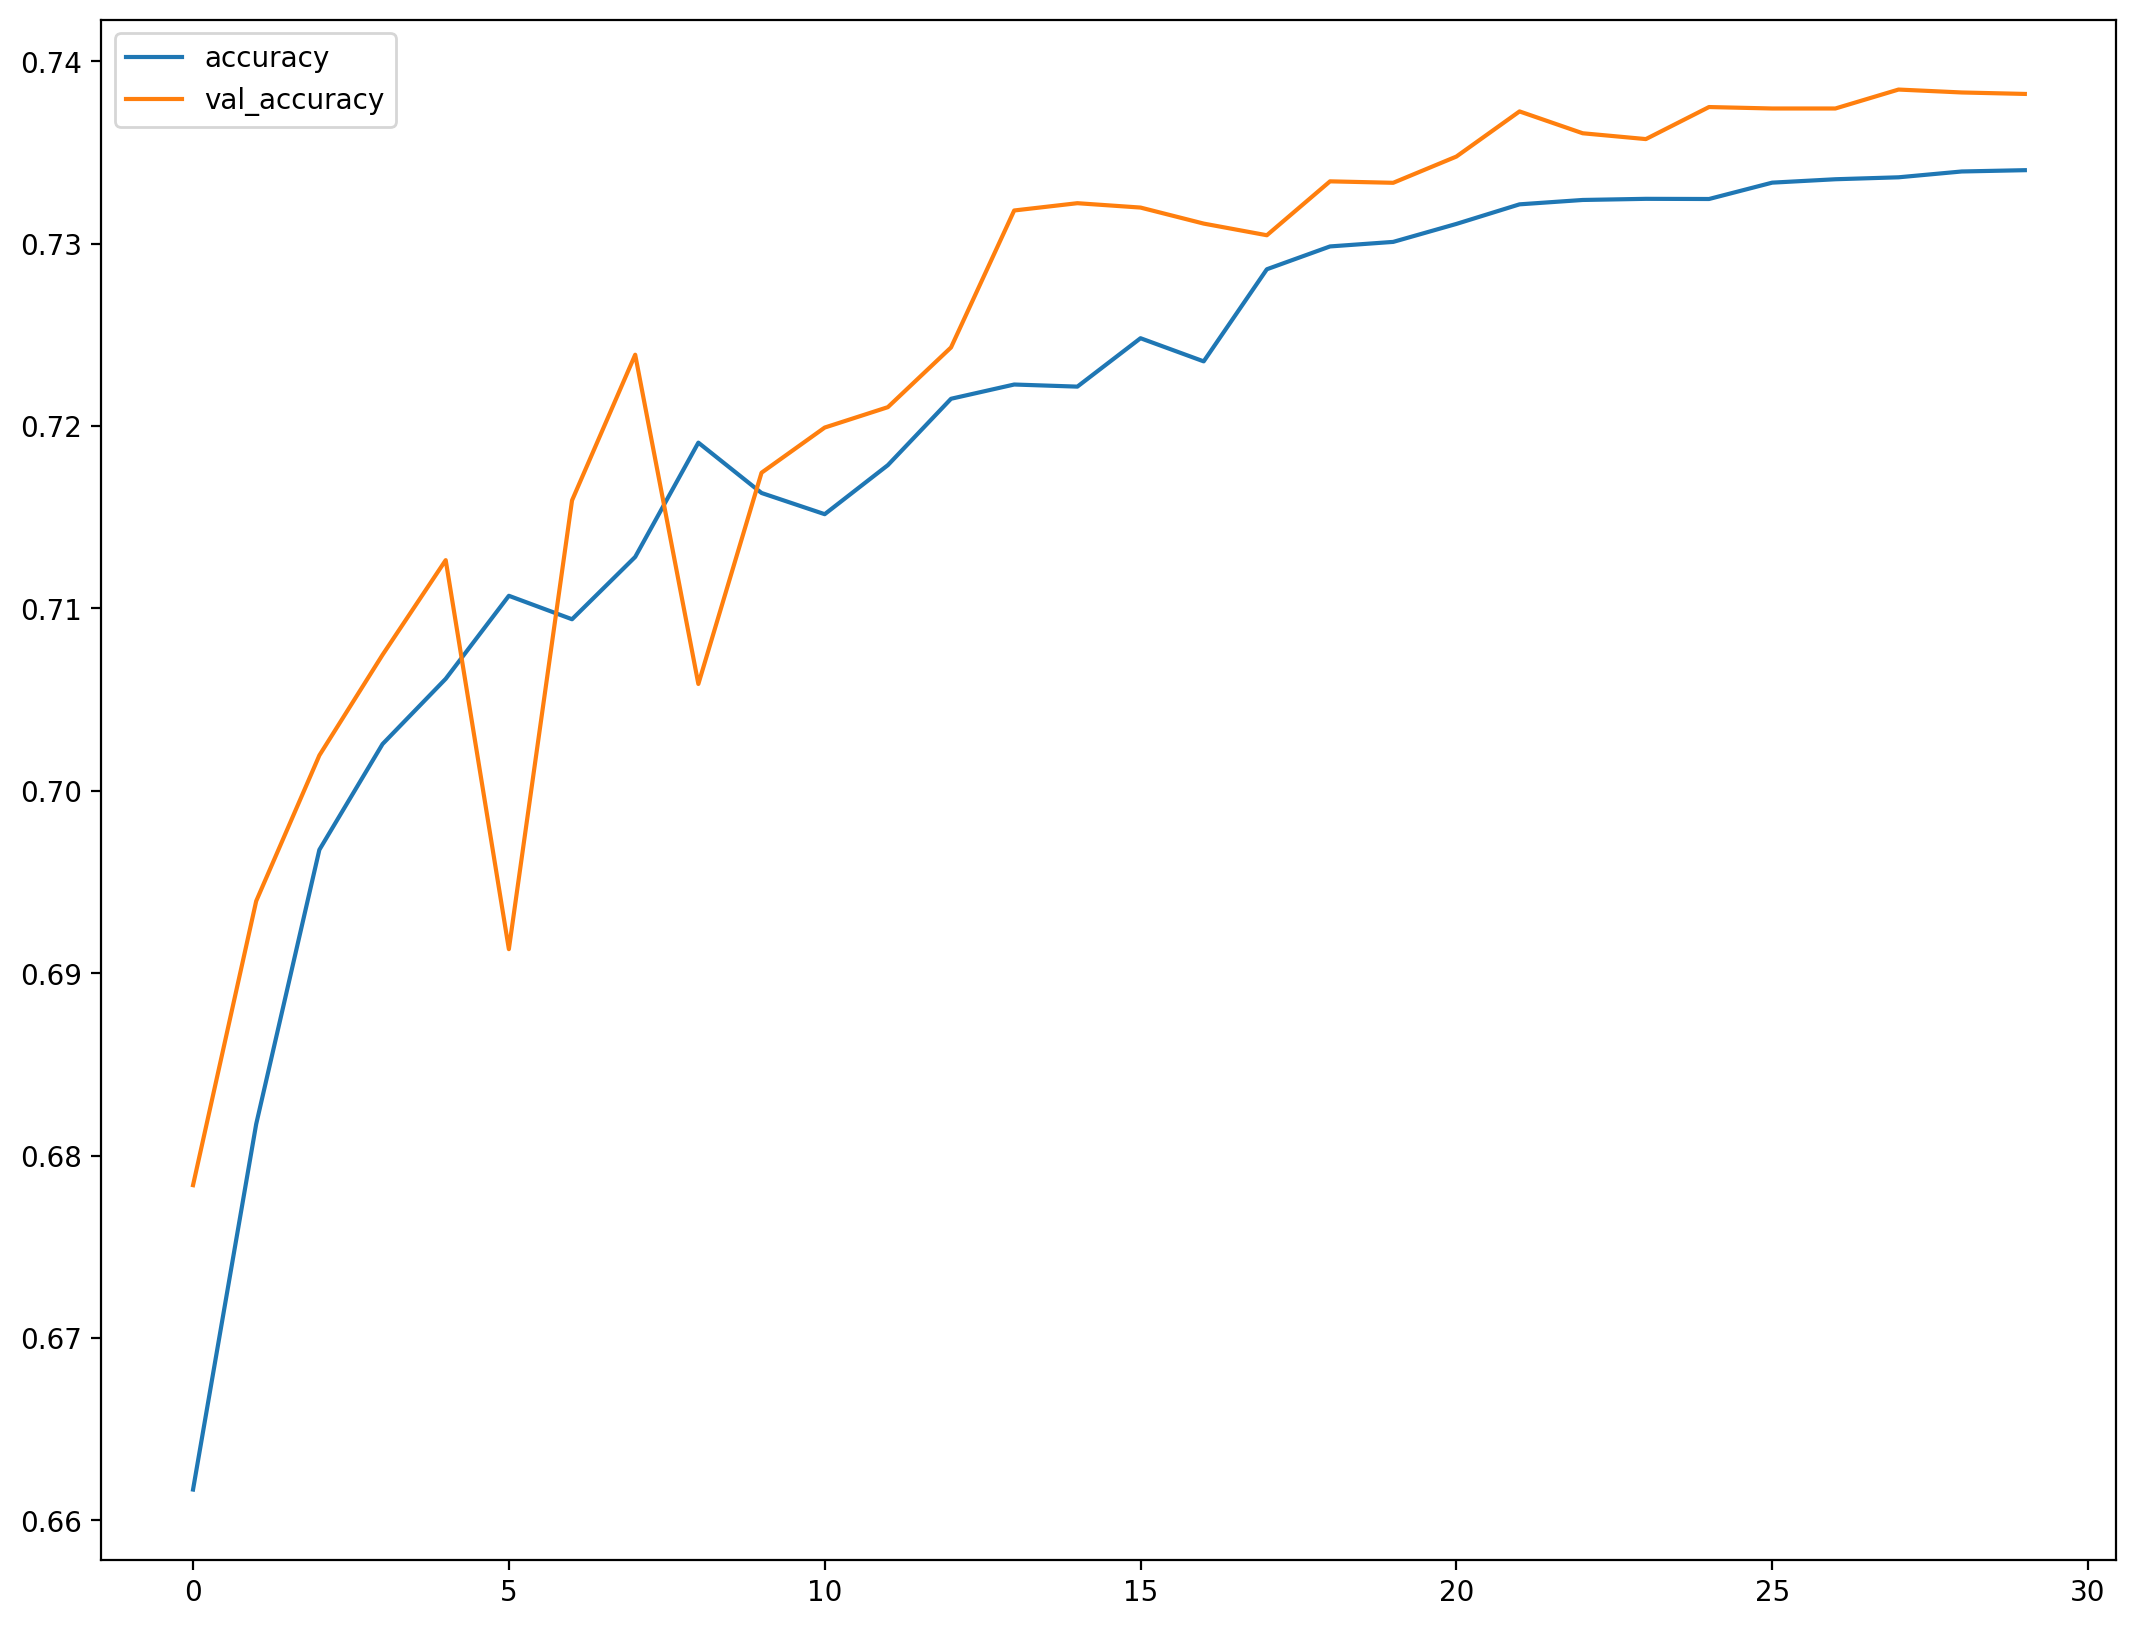

In [48]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [49]:
loss, accuracy = model.evaluate([user_test, item_test], test["ordered"].values)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

979/979 [==============================] - 5s 5ms/step - loss: 0.5240 - accuracy: 0.7311
Test loss: 0.5240
Test accuracy: 0.7311


#### Predict on test set and compute score

In [50]:
y_pred = model.predict([user_test, item_test])
y_pred = np.where(y_pred > 0.5, 1, 0)

 34/979 [>.............................] - ETA: 2s

2023-05-16 18:16:09.723131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


979/979 [==============================] - 3s 3ms/step


In [51]:
def metrics(y_true, y_pred):
    """
    Compute the f1 score, accuracy, recall and precision.

    ------
    Parameters:
    y_true: np.array
        The true labels
    y_pred: np.array
        The predicted labels

    ------
    Returns:
    f1: float
        The f1 score
    acc: float
        The accuracy
    recall: float
        The recall
    precision: float
        The precision
    """
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return f1, acc, recall, precision

f1, acc, recall, precision = metrics(test["ordered"].values, y_pred)
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

F1 score: 0.7411
Accuracy: 0.7311
Recall: 0.7658
Precision: 0.7179


The F1 score is not so bad, but I didn't manage to do better. After trying several implementations (KMeans, Bayesian Personalized Ranking) and different features and hyperparameters on this neural network, I didn't manage to do better than this.

Let's save the model

In [52]:
# save the model
model.save("quentin.fisch_model.h5")

## Submission

It's now time to load the test data and make predictions on it to submit them.

Let's start by loading the test data and preprocessing it

In [53]:
df_users_test = pd.read_csv('./data/test_customers.csv')
df_users_test

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36
1,FWNUI71,Male,NaN,1,1,EN,2018-03-22 20:11:47,2018-03-22 20:11:47
2,LRX7BCH,Male,NaN,1,1,EN,2018-04-17 20:01:15,2018-04-17 20:01:15
3,D96DHMD,Male,NaN,1,1,EN,2018-04-29 22:35:52,2018-04-29 22:35:52
4,88Q8Y5V,Male,1997.0,1,1,EN,2018-05-05 12:38:09,2018-05-05 12:38:09
...,...,...,...,...,...,...,...,...
9763,369I4YD,NaN,NaN,1,1,NaN,2020-03-03 12:03:03,2020-03-03 12:03:16
9764,VUOXW5K,NaN,NaN,1,1,NaN,2020-03-03 12:17:09,2020-03-03 14:04:41
9765,H1S2T2Y,NaN,NaN,1,1,NaN,2020-03-03 12:23:20,2020-03-03 12:24:20
9766,QGPCD5S,NaN,NaN,1,1,NaN,2020-03-03 13:18:23,2020-03-03 13:18:39


In [54]:
df_users_test.akeed_customer_id.value_counts()

JGRG3RQ    4
DSJRR66    3
4X2Y51H    3
P4MAWAE    3
3DDZLWQ    2
          ..
93A2R8G    1
FEQD83D    1
IMH79N0    1
PD692UF    1
RMPE9Z1    1
Name: akeed_customer_id, Length: 9753, dtype: int64

In [55]:
df_users_test = df_users_test.drop_duplicates(subset=['akeed_customer_id'], keep='first')
df_users_test.akeed_customer_id.value_counts()

ICE2DJP    1
BWYP493    1
RE8S7CS    1
60HL0LX    1
QI8AR7S    1
          ..
93A2R8G    1
FEQD83D    1
IMH79N0    1
PD692UF    1
RMPE9Z1    1
Name: akeed_customer_id, Length: 9753, dtype: int64

In [56]:
df_users_test["gender"] = df_users_test["gender"].astype(str).apply(lambda x: "M" if str.upper(x).startswith("M") else ("F" if str.upper(x).startswith("F") else "NA"))
df_users_test

/var/folders/d4/5g8l86tn7gnbb_cwzfq_vd180000gn/T/ipykernel_36973/634284729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_test["gender"] = df_users_test["gender"].astype(str).apply(lambda x: "M" if str.upper(x).startswith("M") else ("F" if str.upper(x).startswith("F") else "NA"))


,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,ICE2DJP,M,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36
1,FWNUI71,M,NaN,1,1,EN,2018-03-22 20:11:47,2018-03-22 20:11:47
2,LRX7BCH,M,NaN,1,1,EN,2018-04-17 20:01:15,2018-04-17 20:01:15
3,D96DHMD,M,NaN,1,1,EN,2018-04-29 22:35:52,2018-04-29 22:35:52
4,88Q8Y5V,M,1997.0,1,1,EN,2018-05-05 12:38:09,2018-05-05 12:38:09
...,...,...,...,...,...,...,...,...
9763,369I4YD,NA,NaN,1,1,NaN,2020-03-03 12:03:03,2020-03-03 12:03:16
9764,VUOXW5K,NA,NaN,1,1,NaN,2020-03-03 12:17:09,2020-03-03 14:04:41
9765,H1S2T2Y,NA,NaN,1,1,NaN,2020-03-03 12:23:20,2020-03-03 12:24:20
9766,QGPCD5S,NA,NaN,1,1,NaN,2020-03-03 13:18:23,2020-03-03 13:18:39


Let's now load the locations data and preprocess it

In [57]:
df_users_test_loc = pd.read_csv('./data/test_locations.csv')
df_users_test_loc

,customer_id,location_number,location_type,latitude,longitude
0,Z59FTQD,0,NaN,126.032278,-9.106019
1,0JP29SK,0,Home,0.278709,-78.623847
2,0JP29SK,1,Home,0.124485,-78.605621
3,0JP29SK,2,NaN,-0.113891,-78.577449
4,0JP29SK,3,NaN,-0.848796,0.136726
...,...,...,...,...,...
16715,L9G4OFV,4,NaN,-0.197722,0.609199
16716,L9G4OFV,5,NaN,-0.343042,0.626064
16717,FDZFYBA,0,Home,-0.974907,-0.177863
16718,UTKHR1C,0,Other,1.058539,0.001628


In [58]:
df_users_test_loc.location_type = df_users_test_loc.location_type.fillna("Other")
df_users_test_loc

,customer_id,location_number,location_type,latitude,longitude
0,Z59FTQD,0,Other,126.032278,-9.106019
1,0JP29SK,0,Home,0.278709,-78.623847
2,0JP29SK,1,Home,0.124485,-78.605621
3,0JP29SK,2,Other,-0.113891,-78.577449
4,0JP29SK,3,Other,-0.848796,0.136726
...,...,...,...,...,...
16715,L9G4OFV,4,Other,-0.197722,0.609199
16716,L9G4OFV,5,Other,-0.343042,0.626064
16717,FDZFYBA,0,Home,-0.974907,-0.177863
16718,UTKHR1C,0,Other,1.058539,0.001628


We can now create the users matrix

In [59]:
customers_ids_test = df_users_test.akeed_customer_id.unique()

df_loc_uniques_test = df_users_test_loc.copy().drop_duplicates(subset=["customer_id"])
df_loc_uniques_test.set_index("customer_id", inplace=True)
df_loc_uniques_test.sort_index(inplace=True)
df_loc_uniques_test

,location_number,location_type,latitude,longitude
customer_id,,,,
000IPH5,0,Home,-0.386541,-78.545227
002U0H9,0,Work,-1.654883,-78.395332
00ICGWM,0,Other,-0.123915,-0.001945
015LTZX,0,Other,19.216488,3.001413
018O5YY,0,Other,-0.166537,-78.571227
...,...,...,...,...
ZZPYP6P,0,Work,-1.179215,-78.451547
ZZR7XVG,0,Home,0.006961,-78.591732
ZZSJX8B,0,Home,-0.676152,0.729432


In [ ]:
df_users_test.set_index("akeed_customer_id", inplace=True)
df_users_test.sort_index(inplace=True)

user_test_matrix = pd.DataFrame(index=customers_ids_test).sort_index()

customer_genders = pd.DataFrame(df_users_test["gender"].apply(lambda genre: 1 if genre == "M" else 2 if genre == "F" else 0))
customer_genders["indexes"] = customers_ids_test
customer_genders.set_index("indexes", inplace=True)
user_test_matrix["genders"] = customer_genders
user_test_matrix["status"] = df_users_test["status"]
user_test_matrix["verified"] = df_users_test["verified"]
user_test_matrix["location_number"] = df_loc_uniques_test["location_number"]
user_test_matrix["latitude"] = df_loc_uniques_test["latitude"].fillna(0)
user_test_matrix["longitude"] = df_loc_uniques_test["longitude"].fillna(0)

df_loc_uniques_test.reset_index(inplace=True)
df_users_test.reset_index(inplace=True)

In [61]:
user_test_features = user_test_matrix.columns.to_numpy()
user_test_matrix.reset_index(inplace=True)
user_test_matrix

,index,genders,status,verified,location_number,latitude,longitude
0,000IPH5,1,1,1,0,-0.386541,-78.545227
1,002U0H9,0,1,1,0,-1.654883,-78.395332
2,00ICGWM,1,1,1,0,-0.123915,-0.001945
3,015LTZX,1,1,1,0,19.216488,3.001413
4,018O5YY,1,1,1,0,-0.166537,-78.571227
...,...,...,...,...,...,...,...
9748,ZZPYP6P,1,1,1,0,-1.179215,-78.451547
9749,ZZR7XVG,0,1,1,0,0.006961,-78.591732
9750,ZZSJX8B,0,1,1,0,-0.676152,0.729432
9751,ZZUD9GZ,1,1,1,0,0.199517,0.531295


In [62]:
user_test_matrix.drop(["location_number"], axis=1, inplace=True)

Now, we can create the dataset and the features, starting with the cartesian product between users and locations

In [63]:
df_users_and_location_test = df_users_test.merge(df_users_test_loc, left_on="akeed_customer_id", right_on="customer_id", how="left")

cartesian_user_test_item = df_users_and_location_test.assign(key=1).merge(df_vendors.assign(key=1), on='key').drop('key', axis=1)
cartesian_user_test_item = cartesian_user_test_item[["akeed_customer_id", "id", "location_number"]]\
    .rename(columns={"akeed_customer_id": "customer_id", "id": "vendor_id"})
cartesian_user_test_item

,customer_id,vendor_id,location_number
0,000IPH5,4,0
1,000IPH5,13,0
2,000IPH5,20,0
3,000IPH5,23,0
4,000IPH5,28,0
...,...,...,...
1631695,ZZZW5ZR,849,1
1631696,ZZZW5ZR,855,1
1631697,ZZZW5ZR,856,1
1631698,ZZZW5ZR,858,1


In [64]:
dataset_submission = cartesian_user_test_item.copy()
dataset_submission

,customer_id,vendor_id,location_number
0,000IPH5,4,0
1,000IPH5,13,0
2,000IPH5,20,0
3,000IPH5,23,0
4,000IPH5,28,0
...,...,...,...
1631695,ZZZW5ZR,849,1
1631696,ZZZW5ZR,855,1
1631697,ZZZW5ZR,856,1
1631698,ZZZW5ZR,858,1


In [65]:
user_submission, item_submission = dataset_to_matrix(dataset_submission, user_test_matrix, item_matrix, user_test_features, vendor_features)

In [66]:
user_submission = scale_vector(user_submission)
item_submission = scale_vector(item_submission)

Finally, let's predict if the user will order from the vendor or not

In [ ]:
model = tf.keras.models.load_model("quentin.fisch_model.h5")

In [67]:
y_pred_submission = model.predict([user_submission, item_submission])
y_pred_submission = np.where(y_pred_submission > 0.5, 1, 0)

50991/50991 [==============================] - 140s 3ms/step


In [68]:
dataset_submission["CID X LOC_NUM X VENDOR"] = dataset_submission.apply(lambda x: x["customer_id"] + " X " + str(x["location_number"]) + " X " + str(x["vendor_id"]), axis=1)
dataset_submission["target"] = y_pred_submission
final_submission = dataset_submission[["CID X LOC_NUM X VENDOR", "target"]]
final_submission

,CID X LOC_NUM X VENDOR,target
0,000IPH5 X 0 X 4,1
1,000IPH5 X 0 X 13,0
2,000IPH5 X 0 X 20,0
3,000IPH5 X 0 X 23,0
4,000IPH5 X 0 X 28,0
...,...,...
1631695,ZZZW5ZR X 1 X 849,0
1631696,ZZZW5ZR X 1 X 855,0
1631697,ZZZW5ZR X 1 X 856,0
1631698,ZZZW5ZR X 1 X 858,0


In [69]:
final_submission["target"].value_counts()

0    1143439
1     488261
Name: target, dtype: int64

In [70]:
final_submission.to_csv("submission.csv", index=False)